##### Intro to Quantum Programming - Spring 2025
## Homework 2: Due 02/21/25

For each exercise below, add as many cells as you want. To evaluate your submission, I will do **Restart and Run All**. . For help with Markdown, see [this link](https://www.markdownguide.org/).

In [ ]:
# Here's a cell for import statements... add more if necessary (or just import below as needed)
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit import transpile

from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_distribution, plot_state_qsphere, plot_state_city
from qiskit.quantum_info import Statevector
from qiskit.primitives import StatevectorSampler as Sampler
import numpy as np
from sv_disc import *

For all the exercises below, you may use the multi-controlled Toffoli gate (known as `mcx`), but don't use higher-level gates from the circuit library, such as AND/OR, adders, comparators, etc. This assignment is about learning how to build those things.

NOTE: This assignment is also about creating modular and reusable software, not just creating quantum circuits. Write Python functions and learn about the Qiskit methods of composing circuits.

---- 
**IMPORTANT**: If any ancilla qubits are used in the circuits below, they must be *uncomputed* to restore them to zero. Failure to uncompute will lead to point deductions.

----
#### Exercise 2.1 (30%)

Define a **function** that creates a quantum circuit that adds a specified $4$-bit *unsigned* integer value to a $4$-qubit input, which represents an unsigned integer. NOTE: This is not to add two quantum numbers together. This is to increment a number by a fixed integer amount. The function must return a `QuantumCircuit` object.

Demonstrate your function with the following increment amounts: $5$, $6$, and $10$. But your function must work with any 4-bit number, and the grader will try other inputs. For each increment value, draw the resulting circuit and verify that it works as expected on classical and superposition states.

For *creativity* points, try to minimize the number of gates required in the circuit. In other words, repeating the +1 circuit $n$ times will work, but try to do better. Consider the examples of $+4$ and $+12$ in the textbook.

I used Qiskit to check my circuit implementation. Below are the circuits.

+5
https://algassert.com/quirk#circuit=%7B%22cols%22:%5B%5B%22X%22%5D,%5B%22%E2%80%A2%22,%22%E2%80%A2%22,%22X%22%5D%5D%7D

+6


+10

Circuit for incrementing by 5:


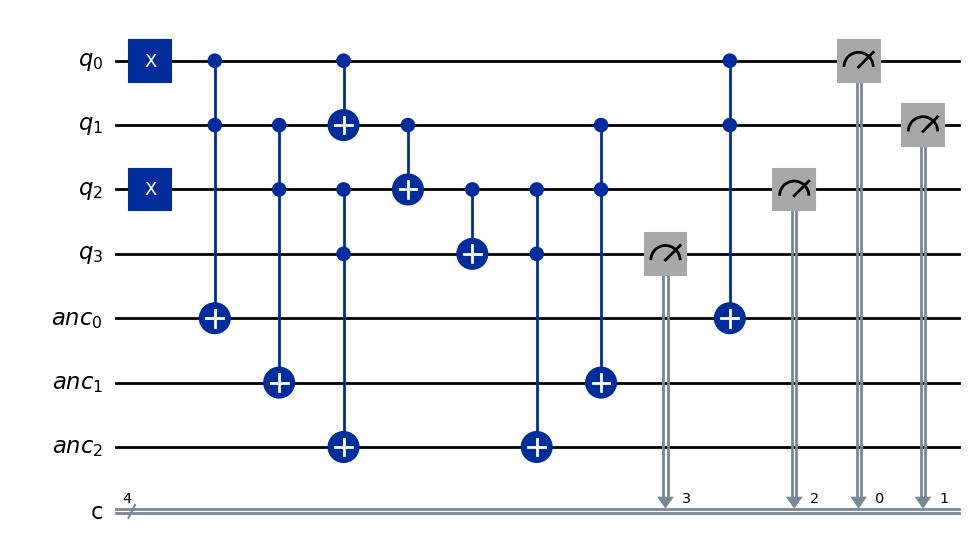

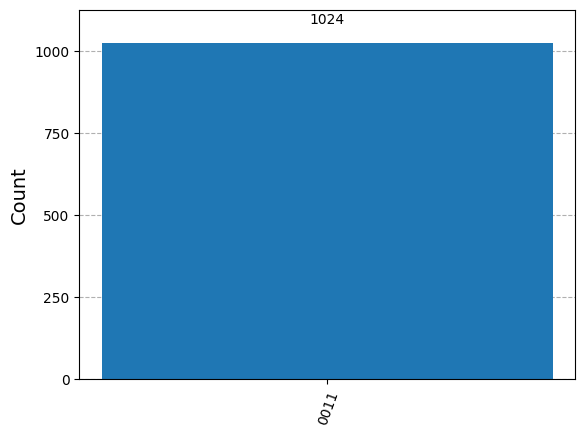

Circuit for incrementing by 6:


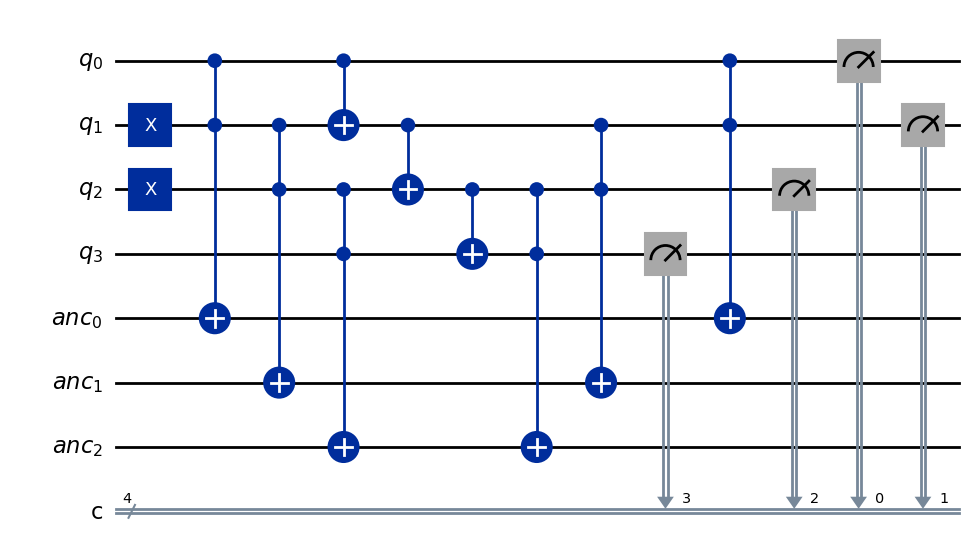

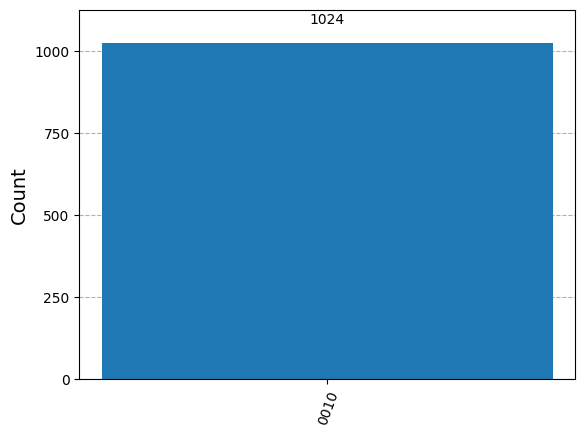

Circuit for incrementing by 10:


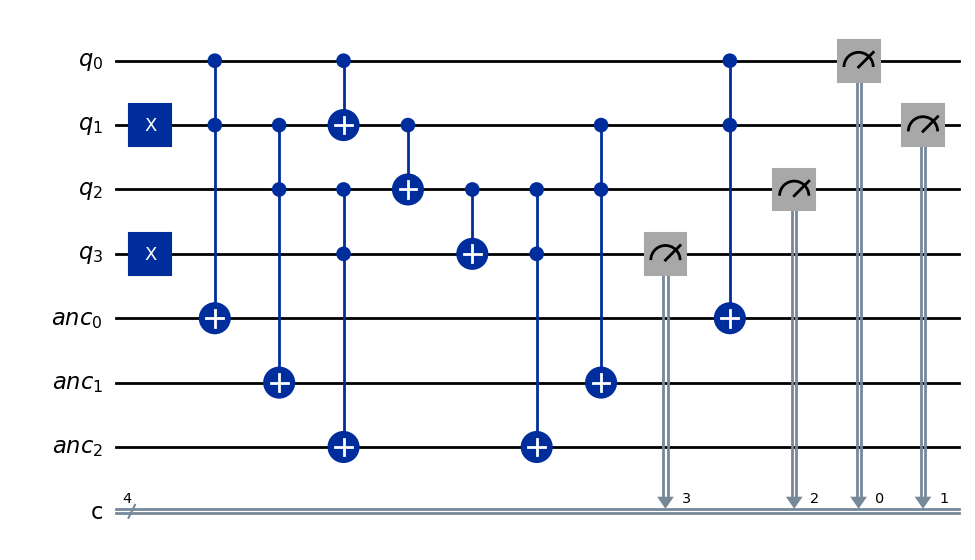

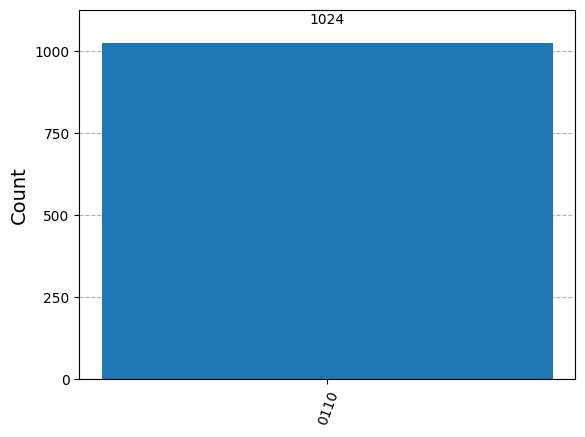

In [13]:
def increment_4bit_qc(increment: int):
    """
    Create a quantum circuit that correctly adds a fixed 4-bit unsigned integer to a 4-qubit input using binary addition.
    
    Parameters:
        increment (int): The unsigned 4-bit integer value to add.
    
    Returns:
        QuantumCircuit: The quantum circuit implementing the controlled binary addition operation.
    """
    if increment < 0 or increment > 15:
        raise ValueError("Increment must be a 4-bit unsigned integer (0 to 15).")
    
    qr = QuantumRegister(4, 'q')  # 4-qubit register for the number
    cr = ClassicalRegister(4, 'c')  # Classical register for measurement
    anc = QuantumRegister(3, 'anc')  # Ancilla qubits for carry propagation
    qc = QuantumCircuit(qr, anc, cr)
    
    # Convert the increment value to binary
    binary_inc = f"{increment:04b}"[::-1]  # Reverse for correct bit ordering
    
    # Apply binary addition using controlled operations
    for i in range(4):
        if binary_inc[i] == '1':
            qc.x(qr[i])  # Flip the bit where the increment has a 1
    
    # Carry propagation for full binary addition
    qc.ccx(qr[0], qr[1], anc[0])  # First carry bit
    qc.ccx(qr[1], qr[2], anc[1])  # Second carry bit
    qc.ccx(qr[2], qr[3], anc[2])  # Third carry bit
    
    qc.cx(qr[0], qr[1])
    qc.cx(qr[1], qr[2])
    qc.cx(qr[2], qr[3])
    
    # Reverse carry propagation (uncomputing ancilla bits)
    qc.ccx(qr[2], qr[3], anc[2])  # Undo third carry
    qc.ccx(qr[1], qr[2], anc[1])  # Undo second carry
    qc.ccx(qr[0], qr[1], anc[0])  # Undo first carry
    
    # Measure the qubits
    qc.measure(qr, cr)
    
    return qc

# Demonstrate for increment values 5, 6, and 10
increment_values = [5, 6, 10]
circuits = {}
for inc in increment_values:
    circuits[inc] = increment_4bit_qc(inc)
    print(f"Circuit for incrementing by {inc}:")
    display(circuits[inc].draw('mpl'))
    
    # Simulate the circuit
    simulator = AerSimulator()
    job = simulator.run(transpile(circuits[inc], simulator), shots=1024)
    result = job.result()
    counts = result.get_counts()
    display(plot_histogram(counts))


----
#### Exercise 2.2 (20%)

Define a **function** that contructs a circuit to test whether a four-qubit input is equal to a specified $4$-bit value ($n$). The circuit will use five qubits: four for the register to test, and one for the result.

Draw the circuit returned by the function for $n = 6$. Show the result of running the circuit on an input state that is an *equal superposition* of all computational basis states.

----
#### Exercise 2.3 (25%)

Using the functions from 2.1 and 2.2 as building blocks, define a **function** that builds a circuit that has two four-qubit quantum registers -- we'll call them $a$ and $b$. The function should include a 4-bit unsigned integer ($n$), and it should increment $b$ by $n$ if and only if $a = n$.  The arguments to your function will be two `QuantumRegister` objects and the integer $n$.

The extra qubit used for the equality test (2.2) should not be included in the parameters of your function. That qubit will be created and used by your function, but will not be provided by the caller of your function. In other words, this is an *ancilla* qubit that is only used for a temporary purpose.

Demonstrate the circuit.

----
#### Exercise 2.4 (25%)

Define a **function** that creates a quantum circuit that creates a 4-qubit equal superposition of computational basis states and then selectively changes the phase of a designated set of basis states. The function has one parameter: a list of integer values that specify the computational bases that will be phase-shifted.  (You may assume that the values are 4-bit integers (0-15).)

For this assignment, the desired phase shift is $90^\circ$ (or $\pi/2$).

For example, suppose the argument is `[2, 9]`.  The output is an equal superposition of $|0\rangle$ through $|15\rangle$ (hint: Hadamard gates!) and states $|2\rangle$ and $|9\rangle$ will be rotated by $\pi/2$.

Draw the circuit and demonstrate that it works correctly for at least two different "interesting" lists. (Consider how to clearly display that the circuit performs correctly.)

You may define additional functions, if desired, and you may use functions that were defined in previous exercises.